In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from scipy.integrate import simps
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

from LoadPretrained import load_model_merged

import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Training Setup

In [2]:
from torchvision import datasets, models, transforms
import os
from ScaleSquareTransform import ScaleSquare
cwd = os.getcwd()

data_transforms = {
    'train': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
}

data_dir = os.path.join(cwd,"dataset")
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=25,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print_every = 100


In [5]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

In [21]:
def train(model, loss_fn, loader, optimizer, num_epochs = 1, print_every=100):
    loss_history = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            loss_data = loss.data[0]
            loss_history.append(loss_data)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss_data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_history

def check_accuracy(model, loader, roc_scores = True):    
    softmax_fn = nn.Softmax()
    prob_scores_corr = []
    prob_scores_incorr = []
    all_preds = []
    all_y = []
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        y_cuda = y.type(torch.cuda.LongTensor)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)

        prob_score = softmax_fn(scores).data.cpu()
        #print(prob_score.size())
        #print(y.size())
        #prob_score_pred = prob_score[y.numpy()]
        #print(prob_score_pred.size())
        #all_preds.append(prob_score_pred)
        all_y.append(y)
        for i,x_i in enumerate(x):
            if (preds[i]!=y[i])[0] == 1:
                incorrect_x[preds[i][0]].append(x_i.unsqueeze(0))
            prob_scores_corr.append(prob_score[i][y[i]])
            prob_scores_incorr.append(prob_score[i][1-y[i]])
            all_preds.append(prob_score[i][1])

    roc_auc = None
    fpr, tpr = None, None
    if roc_scores:
        y_true = torch.cat(all_y,0).numpy()
        fpr, tpr, _ = roc_curve(y_true, all_preds)
        roc_auc = auc(fpr, tpr)

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x, prob_scores_corr, prob_scores_incorr, (roc_auc, fpr, tpr)

In [19]:
def get_incorr_loader(model, incorrects):
    all_inc_val = []
    all_inc_val.extend(incorrects[0])
    all_inc_val.extend(incorrects[1])
    inc_dataset_val = torch.cat(all_inc_val, 0)
    targets_val = torch.cat([torch.LongTensor(len(incorrects[0])).fill_(1), torch.LongTensor(len(incorrects[1])).fill_(0)], 0)
    incorr_val = torch.utils.data.TensorDataset(inc_dataset_val, targets_val)
    incorr_loader_val = torch.utils.data.DataLoader(incorr_val, batch_size=4, shuffle=True)
    return incorr_loader_val

In [7]:
loss_fn = nn.CrossEntropyLoss()

In [8]:
import torchvision.utils
import matplotlib.pyplot as plt

to_pil = torchvision.transforms.ToPILImage()

def show_img(inp):
    img = to_pil(inp)
    plt.imshow(img)

## Train all of the models

### SqueezeNet 1.0

In [27]:
lr_step = .3
lr_range = np.arange(-4.5,-2,lr_step)
learning_rates = [10**np.random.uniform(n,n+lr_step) for n in lr_range]
reg_step = .3
reg_range = np.arange(-3,-1,reg_step)
regs = [10**np.random.uniform(n,n+reg_step) for n in reg_range]
beta0s = [0.9,0.95]
beta1s = [0.99, 0.995, 0.999]
best_acc = -1
best_beta0 = 0.9
best_beta1 = 0.99
best_reg = -1
best_lr = -1
best_model = None

for lr in learning_rates:
    for reg in regs:
        for beta0 in beta0s:
            for beta1 in beta1s:
                squeezenet = load_model_merged('squeezenet1_1', 2)[0]
                squeezenet.cuda()

                optimizer = optim.Adam(squeezenet.parameters(), lr=lr, betas=(best_beta0, best_beta1), weight_decay=reg)
                print("using reg {}, lr {}, beta0 {}, beta1 {}".format(np.log10(reg), np.log10(lr), beta0, beta1))
                train(squeezenet, loss_fn, dset_loaders["train"], optimizer, num_epochs=1)
                acc, _, _, _, _ = check_accuracy(squeezenet, dset_loaders["val"])
                if acc > best_acc:
                    best_acc = acc
                    best_beta0 = beta0
                    best_beta1 = beta1
                    best_reg = reg
                    best_lr = lr
                    best_model = squeezenet
                    print("check acc {}, reg {}, lr {}".format(acc, reg, np.log10(lr)))


print("best acc {}, beta0 {}, beta1 {}, reg {}, lr {}".format(best_acc, best_beta0, best_beta1, np.log10(best_reg), np.log10(best_lr)))

Replacing the following state from initialized squeezenet1_1 : ['classifier.1.weight', 'classifier.1.bias']
using reg -2.941862387804698, lr -4.3794035343291675
Starting epoch 1 / 1
Got 399 / 439 correct (90.89)
check acc 0.908883826879271, reg 0.0011432405289299628, lr -4.3794035343291675
Replacing the following state from initialized squeezenet1_1 : ['classifier.1.weight', 'classifier.1.bias']
using reg -2.941862387804698, lr -4.3794035343291675
Starting epoch 1 / 1
Got 403 / 439 correct (91.80)
check acc 0.9179954441913439, reg 0.0011432405289299628, lr -4.3794035343291675
Replacing the following state from initialized squeezenet1_1 : ['classifier.1.weight', 'classifier.1.bias']
using reg -2.941862387804698, lr -4.3794035343291675
Starting epoch 1 / 1
Got 406 / 439 correct (92.48)
check acc 0.9248291571753986, reg 0.0011432405289299628, lr -4.3794035343291675
Replacing the following state from initialized squeezenet1_1 : ['classifier.1.weight', 'classifier.1.bias']
using reg -2.9418

Process Process-895:
Process Process-896:
Process Process-894:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/cs2

KeyboardInterrupt: 

Process Process-893:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 41, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])


In [ ]:
#torch.save(best_model.state_dict(), os.path.join(cwd,"model_params_sq.pth"))

In [29]:
squeezenet = load_model_merged('squeezenet1_1', 2)[0]
squeezenet.cuda()
##0.007074456977973474, lr -4.3794035343291675
#squeezenet.load_state_dict(torch.load(os.path.join(cwd,"model_params_sq.pth")))
optimizer_sq = optim.Adam(squeezenet.parameters(), lr=10**-4.37, betas=(0.95, 0.995), weight_decay=0.007)
loss_history_sq = train(squeezenet, loss_fn, dset_loaders["train"], optimizer_sq, num_epochs=10)
acc, incorrect_sq, prob_scores_corr, prob_scores_incorr, (roc_auc, fpr, tpr) = check_accuracy(squeezenet, dset_loaders["val"])
print("False negatives:",len(incorrects_sq[0]))
print("False positives:",len(incorrects_sq[1]))

Replacing the following state from initialized squeezenet1_1 : ['classifier.1.weight', 'classifier.1.bias']
Starting epoch 1 / 10
Starting epoch 2 / 10
Starting epoch 3 / 10
Starting epoch 4 / 10
Starting epoch 5 / 10
Starting epoch 6 / 10
Starting epoch 7 / 10
Starting epoch 8 / 10
Starting epoch 9 / 10
Starting epoch 10 / 10
Got 428 / 439 correct (97.49)
False negatives: 3
False positives: 10


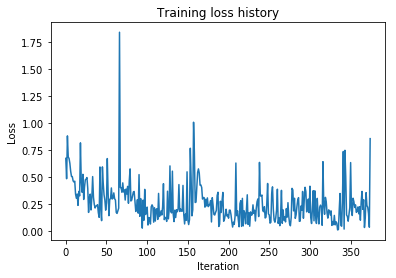

In [24]:
# Plot the training losses
plt.plot(loss_history_sq)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
#torch.save(best_model.state_dict(), os.path.join(cwd,"model_params_sq.pth"))

In [22]:
inc_loader_val = get_incorr_loader(squeezenet, incorrects_sq)
optimizer = optim.Adam(squeezenet.parameters(), lr=10**-3.25, betas=(0.9, 0.99), weight_decay=10**-2.7)
loss_history_after = train(squeezenet, loss_fn, inc_loader_val, optimizer, num_epochs=1)
acc, incorrects_after, _, _, _ = check_accuracy(squeezenet, inc_loader_val, False)
print("False negatives:",len(incorrects_after[0]))
print("False positives:",len(incorrects_after[1]))

acc, incorrects_val, _, _, _ = check_accuracy(squeezenet, dset_loaders['val'], False)
print("False negatives:",len(incorrects_val[0]))
print("False positives:",len(incorrects_val[1]))

Starting epoch 1 / 5
Starting epoch 2 / 5
Starting epoch 3 / 5
Starting epoch 4 / 5
Starting epoch 5 / 5
Got 10 / 13 correct (76.92)
False negatives: 3
False positives: 0
Got 146 / 439 correct (33.26)
False negatives: 293
False positives: 0


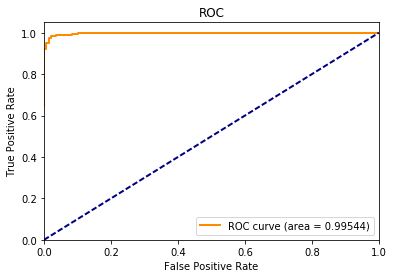

In [14]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc_s)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### SqueezeNet 1.1

In [23]:
model_101 = models.resnet101(pretrained=True)
model_101.fc = nn.Linear(model_101.fc.in_features, 2)
model_101.cuda()

optimizer_101 = optim.Adam(model_101.parameters(), lr=10**-4, betas=(0.9, 0.99), weight_decay=0.009)

loss_history_101 = train(model_101, loss_fn, dset_loaders["train"], optimizer_101, num_epochs=5)
acc, incorrects_101, prob_scores_corr_101, _, f1score_101 = check_accuracy(model_101, dset_loaders["val"])
print("False negatives:",len(incorrects_101[0]))
print("False positives:",len(incorrects_101[1]))
print("F1 score",f1score_101)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /home/chale/.torch/models/resnet101-5d3b4d8f.pth
100.0%

Starting epoch 1 / 5


Starting epoch 2 / 5
Starting epoch 3 / 5
Starting epoch 4 / 5
Starting epoch 5 / 5
Got 725 / 737 correct (98.37)
False negatives: 9
False positives: 3
F1 score 0.983717774763


In [63]:
lr_step = .5
lr_range = np.arange(-5,-3,lr_step)
learning_rates = [10**np.random.uniform(n,n+lr_step) for n in lr_range]
reg_step = .5
reg_range = np.arange(-3,-1,reg_step)
regs = [10**np.random.uniform(n,n+reg_step) for n in reg_range]
beta0s = [0.9,0.95]
beta1s = [0.99, 0.995, 0.999]
best_acc = -1
best_beta0 = 0.9
best_beta1 = 0.99
best_reg = -1
best_lr = -1
best_model = None

for lr in learning_rates:
    for reg in regs:
        #for beta0 in beta0s:
            #for beta1 in beta1s:
        model_101 = models.resnet101(pretrained=True)
        model_101.fc = nn.Linear(model_101.fc.in_features, 2)
        model_101.cuda()

        optimizer = optim.Adam(model_101.parameters(), lr=lr, betas=(best_beta0, best_beta1), weight_decay=reg)
        print("using reg {}, lr {}".format(np.log10(reg), np.log10(lr)))
        train(model_101, loss_fn, dset_loaders["train"], optimizer, num_epochs=1)
        acc, _, _, _, _ = check_accuracy(model_101, dset_loaders["val"])
        if acc > best_acc:
            best_acc = acc
            #best_beta0 = beta0
            #best_beta1 = beta1
            best_reg = reg
            best_lr = lr
            best_model = model_101
            print("check acc {}, reg {}, lr {}".format(acc, reg, np.log10(lr)))


print("best acc {}, beta0 {}, beta1 {}, reg {}, lr {}".format(best_acc, best_beta0, best_beta1, np.log10(best_reg), np.log10(best_lr)))

using reg -2.992665881746138, lr -4.879532049035474
Starting epoch 1 / 1
Got 425 / 439 correct (96.81)
check acc 0.9681093394077449, reg 0.0010170308301054873, lr -4.879532049035474
using reg -2.231556508489795, lr -4.879532049035474
Starting epoch 1 / 1
Got 421 / 439 correct (95.90)
using reg -1.648089713495322, lr -4.879532049035474
Starting epoch 1 / 1
Got 425 / 439 correct (96.81)
using reg -1.3689155381853848, lr -4.879532049035474
Starting epoch 1 / 1
Got 417 / 439 correct (94.99)
using reg -2.992665881746138, lr -4.305812798532243
Starting epoch 1 / 1
Got 428 / 439 correct (97.49)
check acc 0.9749430523917996, reg 0.0010170308301054873, lr -4.305812798532243
using reg -2.231556508489795, lr -4.305812798532243
Starting epoch 1 / 1
Got 432 / 439 correct (98.41)
check acc 0.9840546697038725, reg 0.005867370210086218, lr -4.305812798532243
using reg -1.648089713495322, lr -4.305812798532243
Starting epoch 1 / 1
Got 425 / 439 correct (96.81)
using reg -1.3689155381853848, lr -4.30581

In [26]:
#torch.save(model_101.state_dict(), os.path.join(cwd,"model_params_resnet_101.pth"))

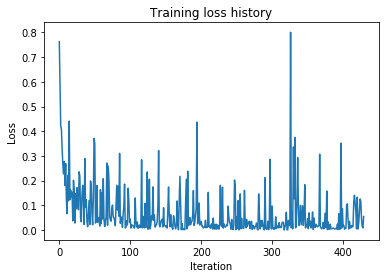

In [27]:
# Plot the training losses
plt.plot(loss_history_101)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

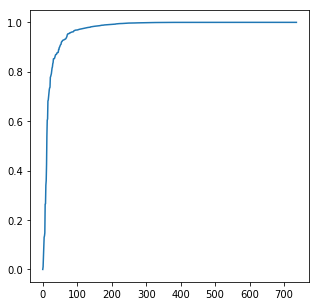

area = 714.478178132


In [28]:
sorted_prob_scores_corr_101 = sorted(prob_scores_corr_101)
plt.plot(sorted_prob_scores_corr_101, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

area = simps(sorted_prob_scores_corr_101, dx=1)
print("area =", area)

### Resnet 152

In [29]:
model_152 = models.resnet152(pretrained=True)
model_152.fc = nn.Linear(model_152.fc.in_features, 2)
model_152.cuda()

optimizer_152 = optim.Adam(model_152.parameters(), lr=10**-4, betas=(0.9, 0.99), weight_decay=0.009)

loss_history_152 = train(model_152, loss_fn, dset_loaders["train"], optimizer_152, num_epochs=7)
acc, incorrects_152, prob_scores_corr_152, _, f1score_152 = check_accuracy(model_152, dset_loaders["val"])
print("False negatives:",len(incorrects_152[0]))
print("False positives:",len(incorrects_152[1]))
print("F1 score",f1score_152)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/chale/.torch/models/resnet152-b121ed2d.pth
100.0%

Starting epoch 1 / 7


Starting epoch 2 / 7
Starting epoch 3 / 7
Starting epoch 4 / 7
Starting epoch 5 / 7
Starting epoch 6 / 7
Starting epoch 7 / 7
Got 726 / 737 correct (98.51)
False negatives: 11
False positives: 0
F1 score 0.985074626866


In [61]:
lr_step = .3
lr_range = np.arange(-5,-4,lr_step)
learning_rates = [10**np.random.uniform(n,n+lr_step) for n in lr_range]
reg_step = .3
reg_range = np.arange(-3,-1.5,reg_step)
regs = [10**np.random.uniform(n,n+reg_step) for n in reg_range]
beta0s = [0.9,0.95]
beta1s = [0.99, 0.995, 0.999]
best_acc = -1
best_beta0 = 0.9
best_beta1 = 0.99
best_reg = -1
best_lr = -1
best_model = None

for lr in learning_rates:
    for reg in regs:
        #for beta0 in beta0s:
            #for beta1 in beta1s:
        model_152 = models.resnet152(pretrained=True)
        model_152.fc = nn.Linear(model_152.fc.in_features, 2)
        model_152.cuda()

        optimizer = optim.Adam(model_152.parameters(), lr=lr, betas=(best_beta0, best_beta1), weight_decay=reg)
        print("using reg {}, lr {}".format(np.log10(reg), np.log10(lr)))
        train(model_152, loss_fn, dset_loaders["train"], optimizer, num_epochs=1)
        acc, _, _, _, _ = check_accuracy(model_152, dset_loaders["val"])
        if acc > best_acc:
            best_acc = acc
            #best_beta0 = beta0
            #best_beta1 = beta1
            best_reg = reg
            best_lr = lr
            best_model = model_152
            print("check acc {}, reg {}, lr {}".format(acc, reg, np.log10(lr)))


print("best acc {}, beta0 {}, beta1 {}, reg {}, lr {}".format(best_acc, best_beta0, best_beta1, np.log10(best_reg), np.log10(best_lr)))

using reg -2.866045697679255, lr -4.810884772587046
Starting epoch 1 / 1
Got 427 / 439 correct (97.27)
check acc 0.9726651480637813, reg 0.0013613014349877549, lr -4.810884772587046
using reg -2.6538777893587095, lr -4.810884772587046
Starting epoch 1 / 1
Got 428 / 439 correct (97.49)
check acc 0.9749430523917996, reg 0.002218820708995389, lr -4.810884772587046
using reg -2.3044203631131643, lr -4.810884772587046
Starting epoch 1 / 1
Got 425 / 439 correct (96.81)
using reg -1.9069760377502116, lr -4.810884772587046
Starting epoch 1 / 1
Got 425 / 439 correct (96.81)
using reg -1.5750301888700542, lr -4.810884772587046
Starting epoch 1 / 1
Got 422 / 439 correct (96.13)
using reg -2.866045697679255, lr -4.523902879623741
Starting epoch 1 / 1
Got 427 / 439 correct (97.27)
using reg -2.6538777893587095, lr -4.523902879623741
Starting epoch 1 / 1
Got 431 / 439 correct (98.18)
check acc 0.9817767653758542, reg 0.002218820708995389, lr -4.523902879623741
using reg -2.3044203631131643, lr -4.52

In [39]:
#torch.save(model_152.state_dict(), os.path.join(cwd,"model_params_resnet_152.pth"))

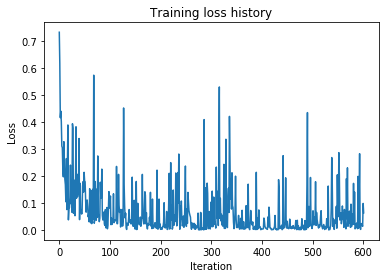

In [30]:
# Plot the training losses
plt.plot(loss_history_152)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

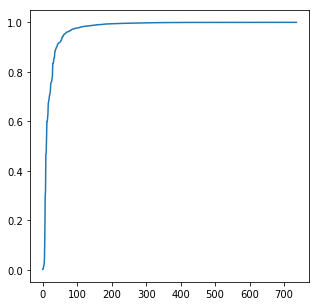

area = 715.673611767


In [31]:
sorted_prob_scores_corr_152 = sorted(prob_scores_corr_152)
plt.plot(sorted_prob_scores_corr_152, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

area = simps(sorted_prob_scores_corr_152, dx=1)
print("area =", area)

Starting epoch 1 / 5
Starting epoch 2 / 5
Starting epoch 3 / 5
Starting epoch 4 / 5
Starting epoch 5 / 5
Got 432 / 439 correct (98.41)
False negatives: 2
False positives: 5


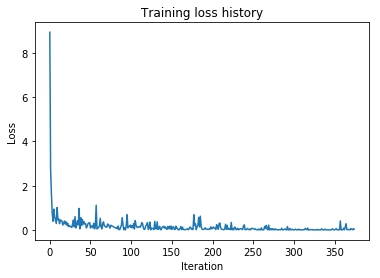

In [6]:
# Here we use transfer learning to create a good model based on vggnet.
# best acc 0.9817767653758542, beta0 0.95, beta1 0.995, logreg -3.7162664807570738, lr -4.592649316320626
model_vgg = models.vgg13(pretrained=True)
model_vgg.classifier[6].out_features = 2
model_vgg.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=10**-4.05194, betas=(0.95, 0.995), weight_decay=10**-3.7162664807570738)

loss_history_vgg = train(model_vgg, loss_fn, dset_loaders["train"], optimizer, num_epochs=5)
acc, incorrects_vgg, prob_scores_corr_vgg, _, f1score_vgg = check_accuracy(model_vgg, dset_loaders["val"])
print("False negatives:",len(incorrects_vgg[0]))
print("False positives:",len(incorrects_vgg[1]))

# Plot the training losses
plt.plot(loss_history_vgg)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

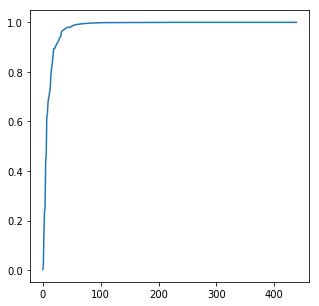

area = 428.174937397


In [7]:
sorted_prob_scores_corr_vgg = sorted(prob_scores_corr_vgg)
plt.plot(sorted_prob_scores_corr_vgg, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

area = simps(sorted_prob_scores_corr_vgg, dx=1)
print("area =", area)

In [8]:
#torch.save(model_vgg.state_dict(), os.path.join(cwd,"model_params_vgg.pth"))

## Ensemble

In [141]:
def check_accuracy_ensemble(models, loader, scheme='ave'):    
    softmax_fn = nn.Softmax()
    prob_scores_corr = []
    prob_scores_incorr = []
    all_preds = []
    all_y = []
    num_models = len(models)
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    for model in models:
        model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        y_cuda = y.type(torch.cuda.LongTensor)

        prob_scores = []
        for model in models:
            scores = model(x_var)
            prob_score = softmax_fn(scores).data.cpu()
            prob_scores.append(prob_score[:,0:2])

        preds = None
        if scheme == 'ave':
            ave_prob_score = torch.stack(prob_scores).sum(0).squeeze(0)/num_models
            preds = ave_prob_score.max(1)[1]
        elif scheme == 'max':
            preds = torch.stack(prob_scores).squeeze(0).max(0)[0].squeeze(0).max(1)[1]
        else:
            raise NotImplementedError
        
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)

        #all_preds.append(prob_score)
        all_y.append(y)
        
        for i,x_i in enumerate(x):
            if (preds[i]!=y[i])[0] == 1:
                incorrect_x[preds[i][0]].append(x_i.unsqueeze(0))
            prob_scores_corr.append(prob_score[i][y[i]])
            prob_scores_incorr.append(prob_score[i][1-y[i]])
            all_preds.append(prob_score[i][1])

    y_true = torch.cat(all_y,0).numpy()
    #y_pred = prob_scores_corr
    fpr, tpr, _ = roc_curve(y_true, all_preds)
    roc_auc_s = roc_auc_score(y_true, all_preds, average='micro')
    roc_auc = auc(fpr, tpr)

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x, prob_scores_corr, prob_scores_incorr, (roc_auc, fpr, tpr, roc_auc_s)

Check validation set against all models

In [7]:
model_18 = models.resnet18(pretrained=True)
model_18.fc = nn.Linear(model_18.fc.in_features, 2)
model_18.cuda()
model_18.load_state_dict(torch.load(os.path.join(cwd,"model_params_extra_incor2.pth")))

model_34 = models.resnet34(pretrained=True)
model_34.fc = nn.Linear(model_34.fc.in_features, 2)
model_34.cuda()
model_34.load_state_dict(torch.load(os.path.join(cwd,"model_params_resnet_34.pth")))

model_50 = models.resnet50(pretrained=True)
model_50.fc = nn.Linear(model_50.fc.in_features, 2)
model_50.cuda()
model_50.load_state_dict(torch.load(os.path.join(cwd,"model_params_resnet_50.pth")))

model_101 = models.resnet101(pretrained=True)
model_101.fc = nn.Linear(model_101.fc.in_features, 2)
model_101.cuda()
model_101.load_state_dict(torch.load(os.path.join(cwd,"model_params_resnet_101.pth")))

model_152 = models.resnet152(pretrained=True)
model_152.fc = nn.Linear(model_152.fc.in_features, 2)
model_152.cuda()
model_152.load_state_dict(torch.load(os.path.join(cwd,"model_params_resnet_152.pth")))

model_vgg = models.vgg13(pretrained=True)
model_vgg.classifier[6].out_features = 2
model_vgg.load_state_dict(torch.load(os.path.join(cwd,"model_params_vgg.pth")))
model_vgg.cuda()


VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU (inplace)
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [13]:
model_ensemble = [model_18, model_34, model_50, model_101, model_152, model_vgg]
acc, incorrects_ave, prob_scores_corr, _, f1score = check_accuracy_ensemble(model_ensemble, dset_loaders["val"], scheme='max')
print("False negatives:",len(incorrects_ave[0]))
print("False positives:",len(incorrects_ave[1]))

Got 438 / 439 correct (99.77)
False negatives: 0
False positives: 1
F1 score 0.997722095672


In [142]:
model_ensemble = [model_18, model_34, model_50, model_101, model_152, model_vgg]
acc, incorrects, prob_scores_corr, _, (roc_auc, fpr, tpr, roc_auc_s) = check_accuracy_ensemble(model_ensemble, dset_loaders["val"], scheme='ave')
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Got 436 / 439 correct (99.32)
False negatives: 3
False positives: 0


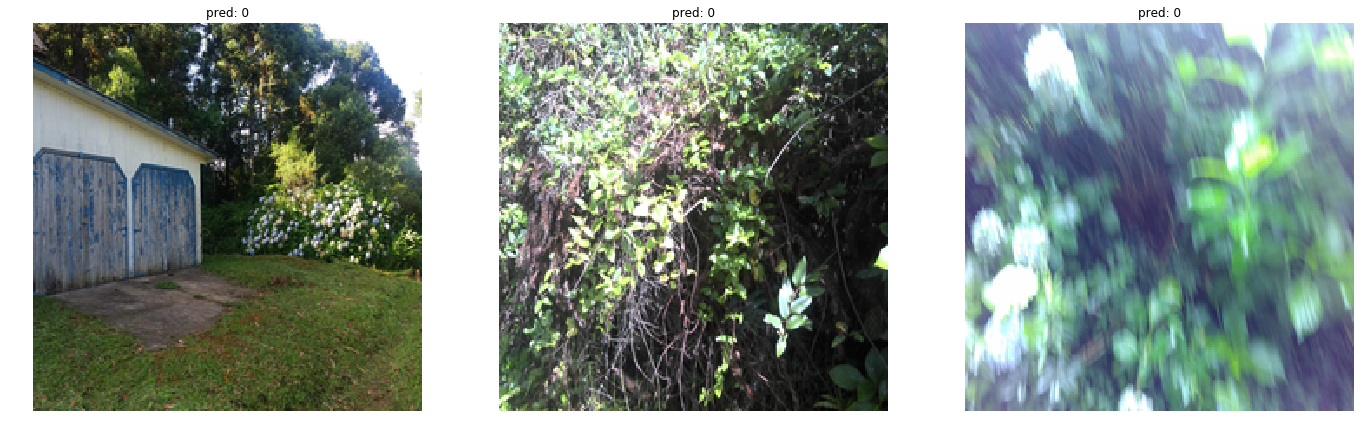

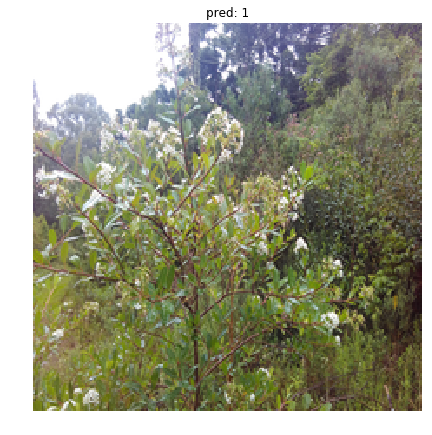

In [48]:
def plot_images(imgs, label):
    num_images = len(imgs)
    fig = plt.figure(figsize=(32, 32)) 
    for j in range(num_images):
        ax = plt.subplot(num_images//4+1, 4, j+1)
        ax.axis('off')
        ax.set_title('pred: {}'.format(label))
        show_img(imgs[j])

plot_images([x.squeeze(0) for x in incorrects[0]], "0")
plot_images([x.squeeze(0) for x in incorrects_ave[1]], "1")

In [69]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X.type(gpu_dtype), requires_grad=True)
    y_var = Variable(y)
    saliency = None
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    scores = model(X_var)
    loss = loss_fn(scores, y_var)
    loss.backward()
    saliency = X_var.grad.data.abs().max(dim=1)[0].squeeze()
    return saliency

def show_saliency_maps(X, y, name, model):
    to_pil = torchvision.transforms.ToPILImage()
    X_tensor = X#torch.cat([x.unsqueeze(0) for x in X], 0)
    y_tensor = y#torch.cuda.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model).unsqueeze(0)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N = X_tensor.size()[0]
    for i in range(N):
        plt.subplot(N, 2, i + 1)
        show_img(X_tensor[i])
        plt.axis('off')
        plt.title(name)
        plt.subplot(N, 2, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 10)
    plt.show()

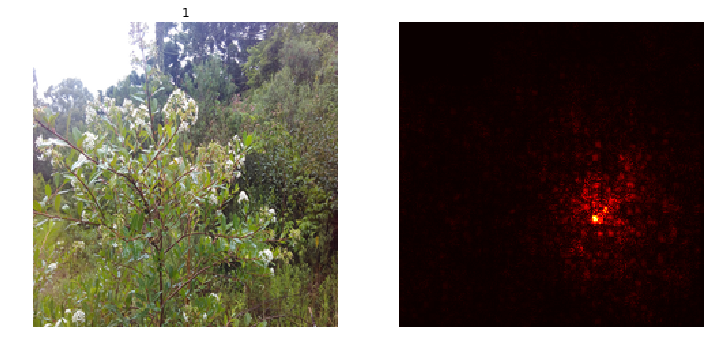

In [70]:
false_positives = incorrects_ave[1]
show_saliency_maps(torch.cat(false_positives,0), torch.zeros(len(false_positives)).type(torch.cuda.LongTensor), '1', model_101)

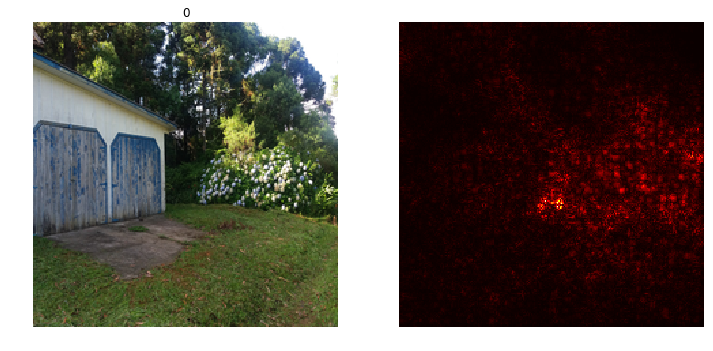

In [71]:
false_negatives = incorrects[0][0:1]
show_saliency_maps(torch.cat(false_negatives,0), torch.zeros(len(false_negatives)).type(torch.cuda.LongTensor), '0', model_101)

In [58]:
gpu_dtype = torch.cuda.FloatTensor

def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and wrap it in a Variable.
    X_fooling = X.clone().type(gpu_dtype)
    X_fooling_var = Variable(X_fooling, requires_grad=True)
    
    learning_rate = 1
    N, D, H, W = X_fooling.size()
    y_var = Variable(torch.cuda.LongTensor(N).fill_(target_y))
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    print(y_var.data[0])
    for t in range(5):
        X_fooling_var = Variable(X_fooling, requires_grad=True)
        scores = model(X_fooling_var)
        y_pred_score, y_pred = scores.max(1)
        print("pred score, index",y_pred_score.data[0,0], y_pred.data[0,0])
        print("target score",scores.data[0,target_y])
        loss = loss_fn(scores, y_var)
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
        loss.backward()
        dX = X_fooling_var.grad.data/X_fooling_var.grad.data.norm()
        X_fooling -= learning_rate*dX
    return X_fooling


def show_fooling(X_tensor, X_fooling, idx, target_label, pred_label):
    x_fooling_cpu = X_fooling.cpu().clone().squeeze(0)
    x_cpu = X_tensor[idx].cpu()
    x_orig_img = to_pil(x_cpu)
    x_fooling = to_pil(x_fooling_cpu)

    plt.subplot(1, 4, 1)
    plt.imshow(x_orig_img)
    plt.title(pred_label)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(x_fooling)
    plt.title(target_label)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    #X_pre = preprocess(Image.fromarray(X[idx]))
    #diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
    diff = x_fooling_cpu-x_cpu
    plt.imshow(to_pil(diff))
    plt.title('Difference')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    #diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
    plt.imshow(to_pil(diff*10))
    plt.title('Magnified difference (10x)')
    plt.axis('off')

    plt.gcf().set_size_inches(12, 5)
    plt.show()
    
def run_fooling(errors, target_y, model):
    X = errors
    for idx, error in enumerate(errors):
        X_tensor_idx = torch.cat([x.cpu().unsqueeze(0) for x in X], 0)#torch.cat([preprocess(Image.fromarray(x)) for x in X], 0)
        X_fooling_idx = make_fooling_image(X_tensor_idx[idx:idx+1], target_y, model)

        scores = model(Variable(X_fooling_idx))
        assert target_y == scores.data.max(1)[1][0, 0], 'The model is not fooled!'

        show_fooling(X_tensor_idx, X_fooling_idx, idx, str(target_y), str(1-target_y))

1
pred score, index 1.1751269102096558 0
target score -1.2408713102340698
t = 1, loss = 2.5015
pred score, index 2.3125767707824707 1
target score 2.3125767707824707
t = 2, loss = 0.0094
pred score, index 4.436413288116455 1
target score 4.436413288116455
t = 3, loss = 0.0002
pred score, index 5.858274936676025 1
target score 5.858274936676025
t = 4, loss = 0.0000
pred score, index 5.203235626220703 1
target score 5.203235626220703
t = 5, loss = 0.0000


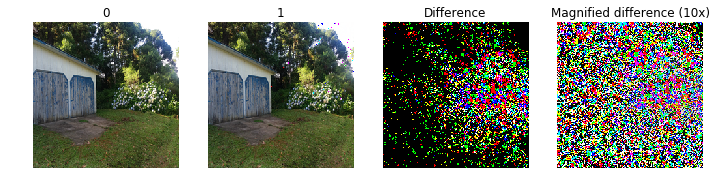

1
pred score, index 0.46444234251976013 0
target score -0.5330601334571838
t = 1, loss = 1.3114
pred score, index 4.150313377380371 1
target score 4.150313377380371
t = 2, loss = 0.0003
pred score, index 6.158846855163574 1
target score 6.158846855163574
t = 3, loss = 0.0000
pred score, index 7.133922100067139 1
target score 7.133922100067139
t = 4, loss = 0.0000
pred score, index 10.426093101501465 1
target score 10.426093101501465
t = 5, loss = 0.0000


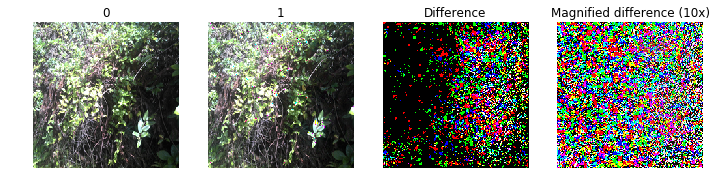

1
pred score, index 0.7114922404289246 1
target score 0.7114922404289246
t = 1, loss = 0.2546
pred score, index 3.07474946975708 1
target score 3.07474946975708
t = 2, loss = 0.0028
pred score, index 6.061043739318848 1
target score 6.061043739318848
t = 3, loss = 0.0000
pred score, index 6.226175785064697 1
target score 6.226175785064697
t = 4, loss = 0.0000
pred score, index 8.7047758102417 1
target score 8.7047758102417
t = 5, loss = 0.0000


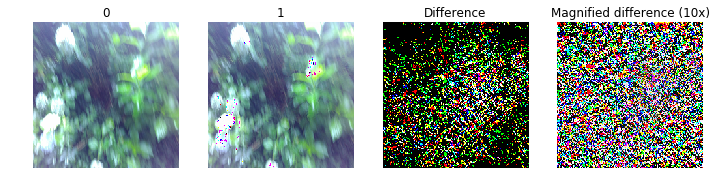

In [59]:
run_fooling(torch.cat(incorrects[0],0), 1, model_101)

0
pred score, index 15.579704284667969 1
target score 11.543631553649902
t = 1, loss = 4.0537
pred score, index 18.021345138549805 0
target score 18.021345138549805
t = 2, loss = 0.0011
pred score, index 25.294389724731445 0
target score 25.294389724731445
t = 3, loss = 0.0000
pred score, index 18.054170608520508 0
target score 18.054170608520508
t = 4, loss = 0.0000
pred score, index 26.26692008972168 0
target score 26.26692008972168
t = 5, loss = 0.0000


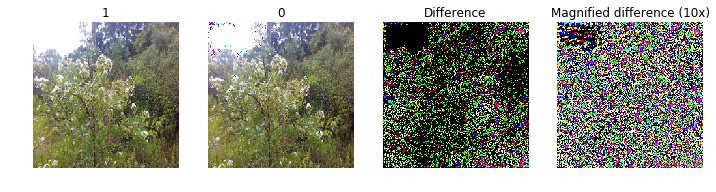

In [64]:
run_fooling(torch.cat(incorrects_ave[1],0), 0, model_vgg)

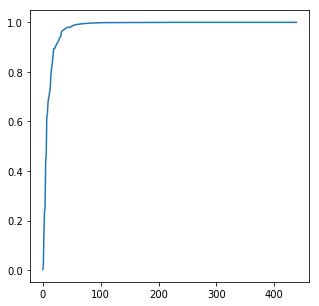

area = 428.128339372


In [78]:
sorted_prob_scores_corr = sorted(prob_scores_corr)
plt.plot(sorted_prob_scores_corr, '-')
plt.gcf().set_size_inches(5, 5)
plt.show()

#area = simps(sorted_prob_scores_corr, dx=1)
from numpy import trapz

area = trapz(sorted_prob_scores_corr, dx=1)
print("area =", area)

In [143]:
print(roc_auc_s)

0.997989620833


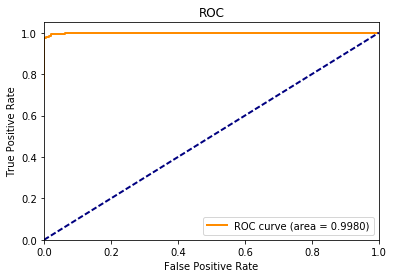

In [144]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [15]:
from TestModelEnsemble import TestModelEnsemble

TestModelEnsemble(model_ensemble, scheme='max').submit()

Submission complete!


Test results: 0.98339 (down from 0.988)

In [16]:
TestModelEnsemble(model_ensemble, scheme='ave').submit()

Submission complete!


Test results: 0.99316 (up from 0.988!)